## 神经网络语言模型: 用 nce_loss 改进


### 运行环境

docker image `tensorflow/tensorflow`, Python 3.4.3

In [1]:
params = dict(filename='../ch1/ZhangAiLing.txt',
              read_size=100000,
              vocab_size=2001,
              embedding_dim=50,
              num_sampled=25,
              learning_rate=1,
              epochs=1000,
              print_cost_every=10,
              batch_size=100)

定义了 params, 用 [这里](http://stackoverflow.com/questions/36427747/scientific-computing-ipython-notebook-how-to-organize-code) 提到的方法就可以从别的 notebook 运行本 notebook. (暂时没用上. 在比较变化参数的效果时会很好用)

In [2]:
%matplotlib inline
from collections import Counter
import time
import jieba
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

### 读取语料，生成训练数据

In [3]:
read_size = params['read_size']
vocab_size = params['vocab_size']
filename = params['filename']

with open(filename, encoding='utf-8') as f:
    corpus = f.read(read_size)

words = [word for word in jieba.cut(corpus) if word not in ' \n']
word_cnt = Counter(words)
vocab = [i[0] for i in word_cnt.most_common(vocab_size - 1)]  # 词表(高频截断)
vocab.insert(0, 'UNK')

# 将语料序列映射到 [0, vocab_size - 1] 内的整数, 未登录词为 0
word_ids = [vocab.index(word) if (word in vocab) else 0 
            for word in words]

# 生成训练数据
inputs_train = np.asarray([[word_ids[i-1], word_ids[i+1]] 
                           for i in range(1, len(word_ids) - 1)])
labels_train = np.asarray(word_ids[1:-1]).reshape(-1, 1)

# 查看截断位置的词频
print('截断处词频: ', word_cnt.most_common(vocab_size)[-5:])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.695 seconds.
Prefix dict has been built succesfully.


截断处词频:  [('不怎么', 3), ('听不见', 3), ('恐怖', 3), ('懂', 3), ('楚', 3)]


In [4]:
# print('len(corpus), len(words), len(vocab), inputs_train.shape, labels_train.shape: ')
len(corpus), len(words), len(vocab), inputs_train.shape, labels_train.shape

(100000, 67488, 2001, (67486, 2), (67486, 1))

### 定义神经网络 和 nce_loss


In [5]:
tf.reset_default_graph()
word_embedding_dim = params['embedding_dim']
num_sampled = params['num_sampled']

word_embeddings = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))
inputs = tf.placeholder(tf.int32, shape=[None, 2], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None, 1], name='labels')

input_embeds = tf.nn.embedding_lookup(word_embeddings, inputs)
context_embeds = tf.reduce_sum(input_embeds, axis=1)

nce_weights = tf.Variable(tf.truncated_normal([vocab_size, word_embedding_dim],
                                              stddev=1.0/np.sqrt(word_embedding_dim)))
nce_biases = tf.Variable(tf.zeros([vocab_size]))

cost = tf.reduce_mean(tf.nn.nce_loss(weights=nce_weights,
                                     biases=nce_biases,
                                     labels=labels,
                                     inputs=context_embeds,
                                     num_sampled=num_sampled,
                                     num_classes=vocab_size))

# print('labels.shape, labels_train.shape, inputs.shape, inputs_train.shape:')
labels.shape, labels_train.shape, inputs.shape, inputs_train.shape

(TensorShape([Dimension(None), Dimension(1)]),
 (67486, 1),
 TensorShape([Dimension(None), Dimension(2)]),
 (67486, 2))

### 训练

In [6]:
learning_rate = params['learning_rate']
epochs = params['epochs']
print_cost_every = params['print_cost_every']
batch_size = params['batch_size']
feed = {inputs: inputs_train, labels: labels_train}  # full-batch feed

In [7]:
train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
costs = []

# 训练集的随机序号
num_inputs = len(labels_train)
order = np.arange(num_inputs)
np.random.shuffle(order)

start_time = time.time()

try:
    for i in range(epochs):
        if i % print_cost_every == 0:
            cost_value = sess.run(cost, feed_dict=feed)
            print("Epoch {: 3d} - Cost: {:.5f}".format(i, cost_value))
            costs.append(cost_value)
        for j in range(0, num_inputs, batch_size):
            batch_index = order[j: j + batch_size]
            batch_inputs = inputs_train[batch_index]
            batch_labels = labels_train[batch_index]
            batch_feed = {inputs: batch_inputs, labels: batch_labels}
            sess.run(train_step, feed_dict=batch_feed)
except KeyboardInterrupt:
    print('KeyboardInterrupt')
finally:
    end_time = time.time()
    print('\ntime: {:.2f} s'.format(end_time - start_time))

Epoch   0 - Cost: 76.02726
Epoch  10 - Cost: 2.88717
Epoch  20 - Cost: 2.62641
Epoch  30 - Cost: 2.37578
Epoch  40 - Cost: 2.40182
Epoch  50 - Cost: 2.37113
Epoch  60 - Cost: 2.33052
Epoch  70 - Cost: 2.28367
Epoch  80 - Cost: 2.27330
Epoch  90 - Cost: 2.19215
Epoch  100 - Cost: 2.16488
Epoch  110 - Cost: 2.54487
Epoch  120 - Cost: 2.08320
Epoch  130 - Cost: 2.00557
Epoch  140 - Cost: 2.21865
KeyboardInterrupt

time: 92.13 s


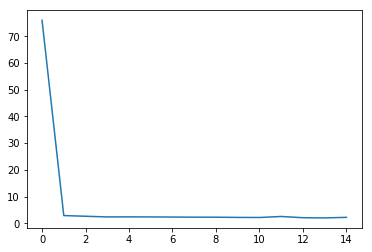

In [8]:
plt.plot(costs);

### 比较词向量相似性

完成 3 个名词各自最相近的 Top 10 个词的检索

In [9]:
def find_similar_words(words):
    validate_ids = [vocab.index(word) for word in validate_words]
    validate_inputs = tf.constant(validate_ids, dtype=tf.int32)

    norm = tf.sqrt(tf.reduce_sum(tf.square(word_embeddings), 1, keep_dims=True))
    normalized_embeddings = word_embeddings / norm
    validate_embeddings = tf.nn.embedding_lookup(normalized_embeddings, validate_inputs)

    similarity = tf.matmul(validate_embeddings, normalized_embeddings, transpose_b=True)
    sim_values = sess.run(similarity, feed_dict=feed)
    for i in range(len(validate_words)):
        word = validate_words[i]
        similar_ids = (-sim_values[i, :]).argsort()[1: 11]
        similar_words = [vocab[j] for j in similar_ids]
        print('similar to {}:'.format(word))
        print(similar_words)

validate_words = ['叔惠', '家里', '茶杯', '手套']
find_similar_words(validate_words)

similar to 叔惠:
['世钧', '慕瑾', '曼桢', '阿宝', '顾太太', '两人', '他', '可笑', '翠芝', '啸桐']
similar to 家里:
['伏', '上次', '赌气', '里头', '厂里', '花', '不在乎', '大约', '一幢', '每天']
similar to 茶杯:
['灯火', '鞋子', '窗前', '枕头', '同学', '马车', '铁箱', '箱子', '茶叶', '卧室']
similar to 手套:
['钟', '一双', '狗', '还会', '印象', '老鼠', '留下', '个人', '台灯', '声浪']


### 模型改进效果

* 普通 softmax + `tf.nn.sparse_softmax_cross_entropy_with_logits`: 
    * 来自 ch4 task3 `nn_language_model.ipynb` 之 v4a
    * 训练时间约 450 s
* nce_loss: 
    * 训练时间约 100 s
    * 由于前提条件不完全相同, 以上只是粗略比较. 但可以看出 nce_loss 对训练速度的提升非常明显.